In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

In [30]:
# Data import
df = pd.read_csv('../data/fetal_health.csv')

##### Data overview and exploration

In [31]:
# Overview data availability and quality
df.head()
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline value                                          2126 non-null   float64
 1   accelerations                                           2126 non-null   float64
 2   fetal_movement                                          2126 non-null   float64
 3   uterine_contractions                                    2126 non-null   float64
 4   light_decelerations                                     2126 non-null   float64
 5   severe_decelerations                                    2126 non-null   float64
 6   prolongued_decelerations                                2126 non-null   float64
 7   abnormal_short_term_variability                         2126 non-null   float64
 8   mean_value_of_short_term_variability  

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
count,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.00000,...,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000
mean,133.303857,0.003178,0.009481,0.004366,0.001889,0.000003,0.000159,46.990122,1.332785,9.84666,...,93.579492,164.025400,4.068203,0.323612,137.452023,134.610536,138.090310,18.808090,0.320320,1.304327
std,9.840844,0.003866,0.046666,0.002946,0.002960,0.000057,0.000590,17.192814,0.883241,18.39688,...,29.560212,17.944183,2.949386,0.706059,16.381289,15.593596,14.466589,28.977636,0.610829,0.614377
min,106.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.200000,0.00000,...,50.000000,122.000000,0.000000,0.000000,60.000000,73.000000,77.000000,0.000000,-1.000000,1.000000
25%,126.000000,0.000000,0.000000,0.002000,0.000000,0.000000,0.000000,32.000000,0.700000,0.00000,...,67.000000,152.000000,2.000000,0.000000,129.000000,125.000000,129.000000,2.000000,0.000000,1.000000
50%,133.000000,0.002000,0.000000,0.004000,0.000000,0.000000,0.000000,49.000000,1.200000,0.00000,...,93.000000,162.000000,3.000000,0.000000,139.000000,136.000000,139.000000,7.000000,0.000000,1.000000
75%,140.000000,0.006000,0.003000,0.007000,0.003000,0.000000,0.000000,61.000000,1.700000,11.00000,...,120.000000,174.000000,6.000000,0.000000,148.000000,145.000000,148.000000,24.000000,1.000000,1.000000
max,160.000000,0.019000,0.481000,0.015000,0.015000,0.001000,0.005000,87.000000,7.000000,91.00000,...,159.000000,238.000000,18.000000,10.000000,187.000000,182.000000,186.000000,269.000000,1.000000,3.000000


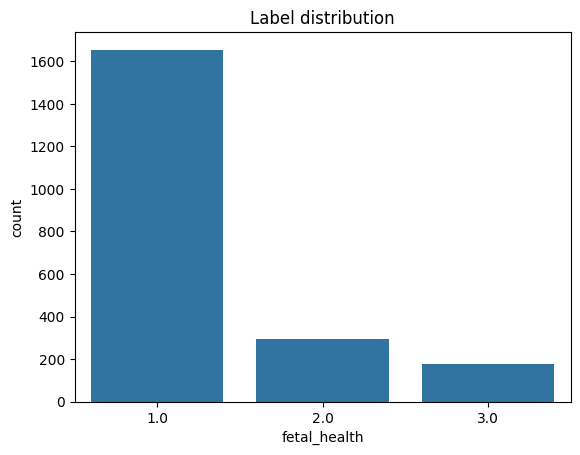

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# Check label count
df['fetal_health'].value_counts()

# Visualize
sns.countplot(x='fetal_health', data=df)
plt.title("Label distribution")
plt.show()

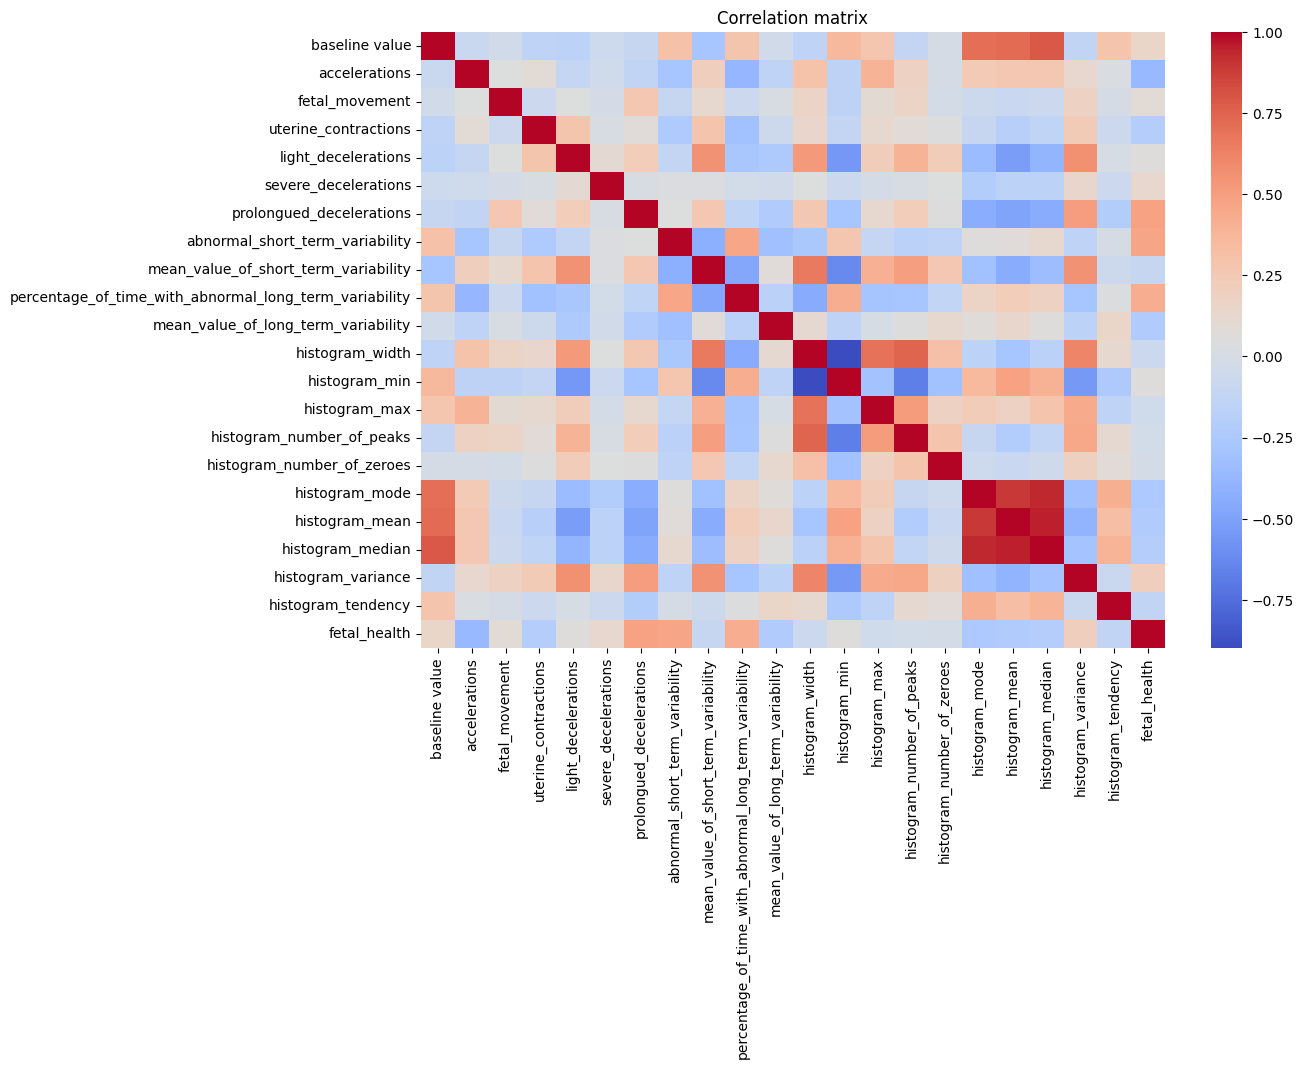

In [33]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), cmap='coolwarm', annot=False)
plt.title("Correlation matrix")
plt.show()

4 Features mit |Korrelation| ≥ 0.3:
['prolongued_decelerations', 'abnormal_short_term_variability', 'percentage_of_time_with_abnormal_long_term_variability', 'accelerations']


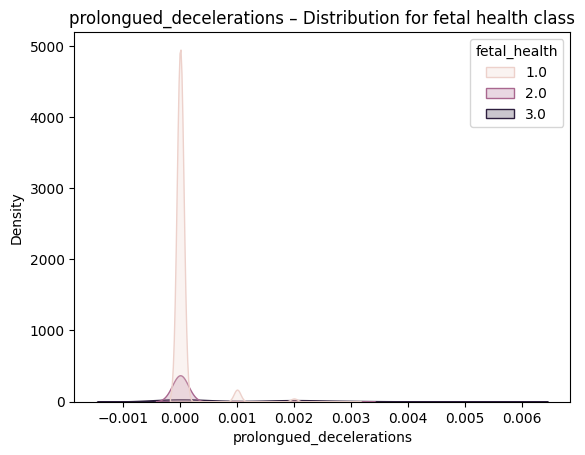

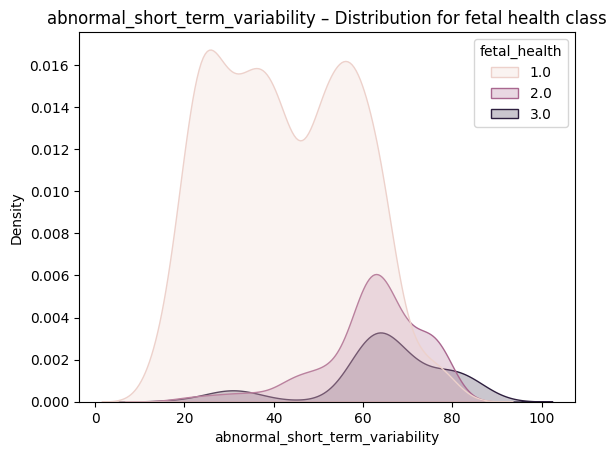

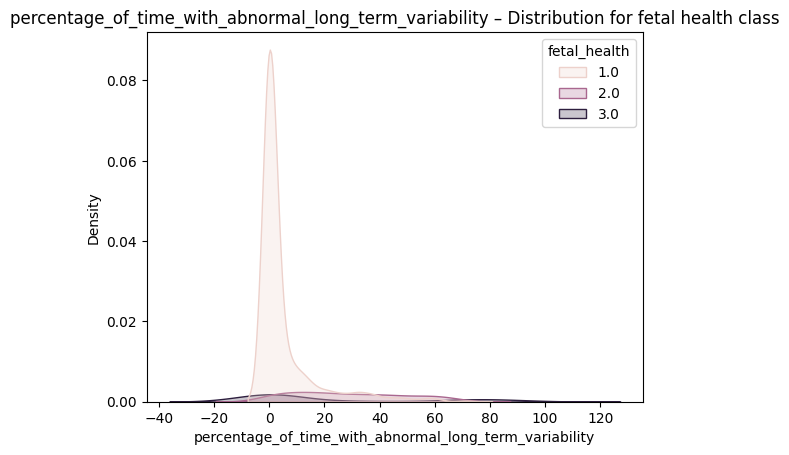

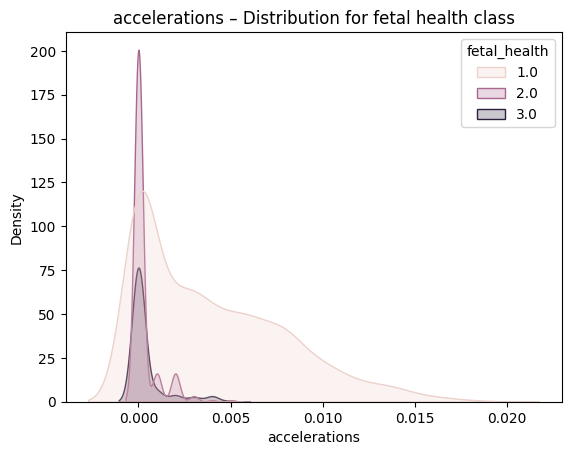

In [34]:
# Check health distribution for intensively correlating features
significant_corr_threshold = 0.3
corr_matrix = df.corr(numeric_only=True)
corr_with_target = corr_matrix['fetal_health'].abs().sort_values(ascending=False)

correlating_features = corr_with_target[(corr_with_target >= significant_corr_threshold) & (corr_with_target.index != 'fetal_health')].index.tolist()

print(f"{len(correlating_features)} Features mit |Korrelation| ≥ {significant_corr_threshold}:")
print(correlating_features)

for col in correlating_features:
    sns.kdeplot(data=df, x=col, hue='fetal_health', fill=True)
    plt.title(f"{col} – Distribution for fetal health class")
    plt.show()

In [35]:
# Split labels from Data
X = df.drop('fetal_health', axis=1)
y = df['fetal_health']

In [36]:
# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [37]:
# Binarize for ROC-curves (Multiclass)
y_test_bin = label_binarize(y_test, classes=[1, 2, 3])
n_classes = y_test_bin.shape[1]

In [38]:
# Models and hyperparameter grids
models = {
    "RandomForest": {
        "model": RandomForestClassifier(random_state=42, class_weight='balanced'),
        "params": {
            "classifier__n_estimators": [100, 200],
            "classifier__max_depth": [None, 10, 20],
            "classifier__min_samples_split": [2, 5]
        }
    },
    "LogisticRegression": {
        "model": LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
        "params": {
            "classifier__C": [0.1, 1, 10],
            "classifier__solver": ["lbfgs", "liblinear"]
        }
    },
    "SVM": {
        "model": SVC(class_weight='balanced', probability=True, random_state=42),
        "params": {
            "classifier__C": [0.1, 1, 10],
            "classifier__kernel": ["linear", "rbf"]
        }
    }
}


=== Training RandomForest ===


Best Parameters: {'classifier__max_depth': 10, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}
Classification Report:
              precision    recall  f1-score   support

         1.0      0.978     0.934     0.955       332
         2.0      0.681     0.831     0.748        59
         3.0      0.865     0.914     0.889        35

    accuracy                          0.918       426
   macro avg      0.841     0.893     0.864       426
weighted avg      0.927     0.918     0.921       426

Balanced Accuracy: 0.8928430428736739
Confusion Matrix:
[[310  21   1]
 [  6  49   4]
 [  1   2  32]]


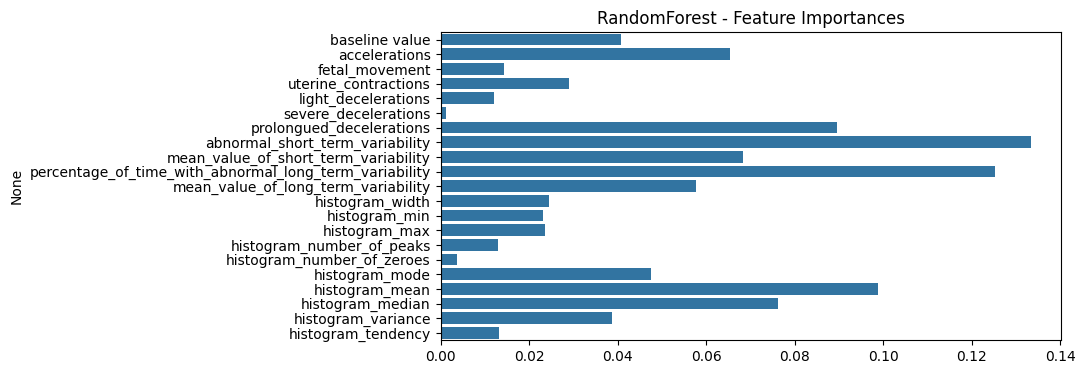

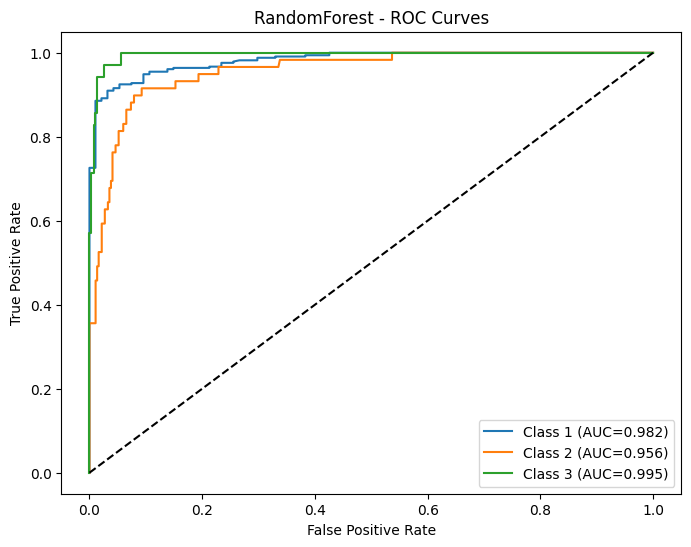


=== Training LogisticRegression ===


/home/repos/FetalHealthClassification/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/home/repos/FetalHealthClassification/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/home/repos/FetalHealthClassification/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is depr

Best Parameters: {'classifier__C': 1, 'classifier__solver': 'lbfgs'}
Classification Report:
              precision    recall  f1-score   support

         1.0      0.986     0.880     0.930       332
         2.0      0.528     0.797     0.635        59
         3.0      0.683     0.800     0.737        35

    accuracy                          0.862       426
   macro avg      0.733     0.825     0.767       426
weighted avg      0.898     0.862     0.873       426

Balanced Accuracy: 0.8253760805935606
Confusion Matrix:
[[292  35   5]
 [  4  47   8]
 [  0   7  28]]


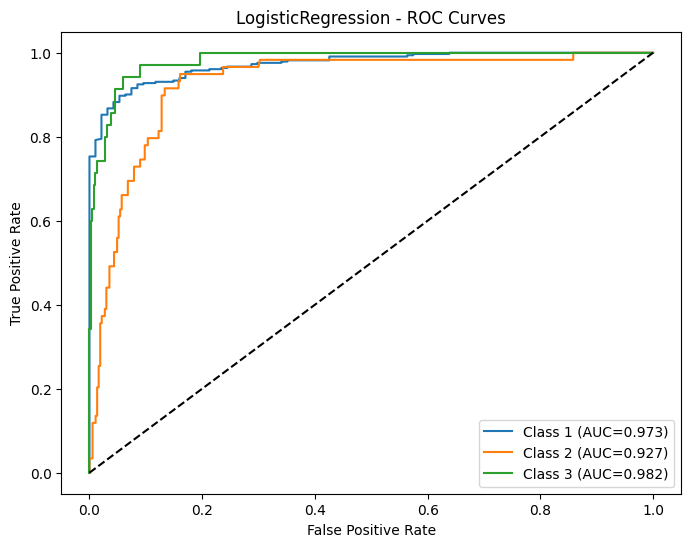


=== Training SVM ===
Best Parameters: {'classifier__C': 1, 'classifier__kernel': 'rbf'}
Classification Report:
              precision    recall  f1-score   support

         1.0      0.977     0.904     0.939       332
         2.0      0.595     0.847     0.699        59
         3.0      0.829     0.829     0.829        35

    accuracy                          0.890       426
   macro avg      0.800     0.860     0.822       426
weighted avg      0.912     0.890     0.897       426

Balanced Accuracy: 0.8598811711737994
Confusion Matrix:
[[300  29   3]
 [  6  50   3]
 [  1   5  29]]


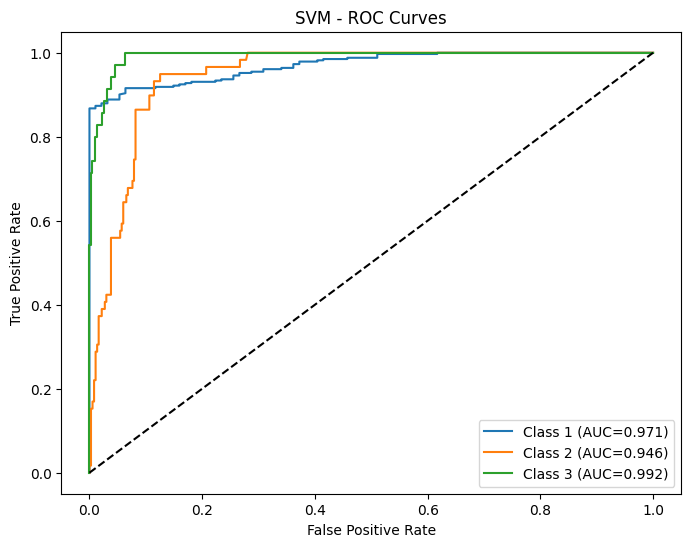

In [39]:
# Pipeline, GridSearchCV and evaluation
best_models = {}

for model_name, mp in models.items():
    print(f"\n=== Training {model_name} ===")
    
    pipeline = ImbPipeline([
        ('smote', SMOTE(random_state=42)),
        ('scaler', StandardScaler()),
        ('classifier', mp['model'])
    ])
    
    grid = GridSearchCV(
        pipeline,
        param_grid=mp['params'],
        cv=5,
        scoring='balanced_accuracy',
        n_jobs=-1
    )
    
    grid.fit(X_train, y_train)
    
    print("Best Parameters:", grid.best_params_)
    
    y_pred = grid.predict(X_test)
    
    # Evaluation
    print("Classification Report:")
    print(classification_report(y_test, y_pred, digits=3))
    
    print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    best_models[model_name] = grid.best_estimator_
    
    # Feature importances
    if hasattr(grid.best_estimator_.named_steps['classifier'], "feature_importances_"):
        importances = grid.best_estimator_.named_steps['classifier'].feature_importances_
        features = X.columns
        plt.figure(figsize=(8,4))
        sns.barplot(x=importances, y=features)
        plt.title(f"{model_name} - Feature Importances")
        plt.show()
    
    # ROC curves (Multiclass)
    if hasattr(grid.best_estimator_.named_steps['classifier'], "predict_proba"):
        y_score = grid.best_estimator_.predict_proba(X_test)
        plt.figure(figsize=(8,6))
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f"Class {i+1} (AUC={roc_auc:.3f})")
        plt.plot([0,1],[0,1],'k--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"{model_name} - ROC Curves")
        plt.legend()
        plt.show()


=== Modellvergleich ===
                Model  Balanced Accuracy  Macro F1-Score  Accuracy
0        RandomForest              0.893           0.864     0.918
2                 SVM              0.860           0.822     0.890
1  LogisticRegression              0.825           0.767     0.862


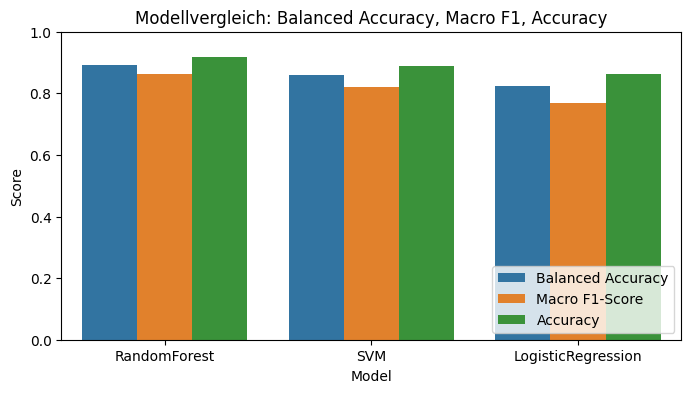

In [40]:
from sklearn.metrics import f1_score, accuracy_score

# Saving results
results = []

for model_name, model in best_models.items():
    y_pred = model.predict(X_test)
    
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    acc = accuracy_score(y_test, y_pred)
    
    results.append({
        "Model": model_name,
        "Balanced Accuracy": round(bal_acc, 3),
        "Macro F1-Score": round(macro_f1, 3),
        "Accuracy": round(acc, 3)
    })

# Results as df
results_df = pd.DataFrame(results).sort_values(by="Balanced Accuracy", ascending=False)
print("\n=== Modellvergleich ===")
print(results_df)

# Visualization
plt.figure(figsize=(8,4))
sns.barplot(data=results_df.melt(id_vars="Model"), x="Model", y="value", hue="variable")
plt.title("Modellvergleich: Balanced Accuracy, Macro F1, Accuracy")
plt.ylabel("Score")
plt.ylim(0,1)
plt.legend(loc="lower right")
plt.show()
